# A simple example

This notebooks provides a basic `pythonradex` example. We will consider the non-LTE radiative transfer of CO without dust effects.

In [1]:
from pythonradex import radiative_transfer, helpers
from scipy import constants
import matplotlib.pyplot as plt
import numpy as np

Initialise the source. We choose a static slab for the geometry and a rectangular line profile with a FWHM of 1 km/s.

In [2]:
datafilepath = "./co.dat"  # file downloaded from EMAA or LAMDA database
geometry = "static slab"
line_profile_type = "rectangular"
width_v = 1 * constants.kilo
source = radiative_transfer.Source(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

Next, we need to set the parameters of the source. Note that `pythonradex` uses SI units.

In [3]:
N = 1e16 / constants.centi**2  # CO column density in m-2
Tkin = 120  # kinetic temperature in [K]
# collider densities in m-3:
collider_densities = {
    "para-H2": 2e2 / constants.centi**3,
    "ortho-H2": 6e2 / constants.centi**3,
}
# external background: CMB at redshift 0. For no background, simply set ext_background=0.
# You can also provide your own function for the background. It should take an array
# of frequencies as input and return the radiation field at those frequencies in units
# of W/m2/Hz/sr
ext_background = helpers.generate_CMB_background(z=0)
# no dust in this example:
T_dust = 0
tau_dust = 0
source.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

Now, we can solve the radiative transfer

In [4]:
source.solve_radiative_transfer()

We will now inspect the results, focussing on the 2-1 transition. As this transitions is listed 2nd in the LAMDA file, its index is 1 (the index starts with 0).

Let's first check the optical depth:

In [5]:
index_21 = 1
print(
    f"optical depth at line center: {source.tau_nu0_individual_transitions[index_21]:.3g}"
)

optical depth at line center: 1.37


Turns out the 2-1 transition is optically thick. Next, let's check the excitation temperature:

In [6]:
print(f"Tex: {source.Tex[index_21]:.3g} K")

Tex: 21 K


We are clearly in the non-LTE regime: $T_\mathrm{ex}$ is much smaller than $T_\mathrm{kin}$. This is expected, because the critical density of CO 2-1 is roughly $10^5$ cm$^{-3}$, which is significanlty higher than our input collider density.

Next, let us check the frequency-integrated flux and intensity. For the flux, let us assume the source has an area of 1 au$^2$ at a distance of 100 pc.

In [7]:
area = (1 * constants.au) ** 2
distance = 100 * constants.parsec
solid_angle = area / distance**2
# we can get the fluxes of several transitions by providing a list of indices,
# or of a single transition, as here:
transitions = index_21
flux_21 = source.frequency_integrated_emission(
    output_type="flux", solid_angle=solid_angle, transitions=transitions
)
print(f"flux of CO 2-1: {flux_21:.3g} W/m2")
intensity_21 = source.frequency_integrated_emission(
    output_type="intensity", transitions=transitions
)
print(f"intensity of CO 2-1: {intensity_21:.3g} W/m2/sr")

flux of CO 2-1: 3.5e-25 W/m2
intensity of CO 2-1: 1.49e-10 W/m2/sr


We can also get the emission (specific intensity, flux density or brightness temperature) and the optical depth as functions of frequency (although in this particular case, that's not very interesting because the line profile is rectangular.

Text(0, 0.5, 'optical depth [-]')

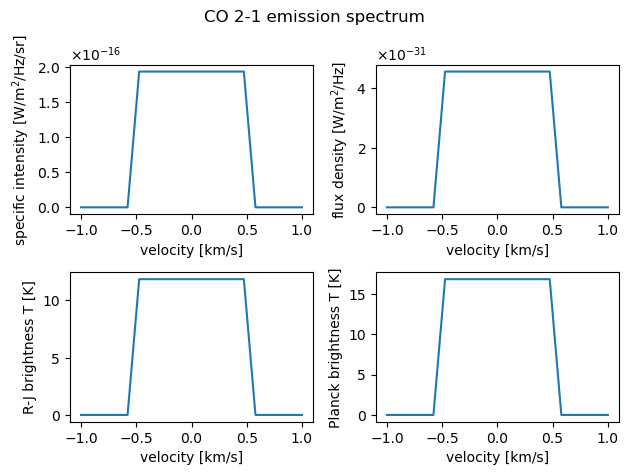

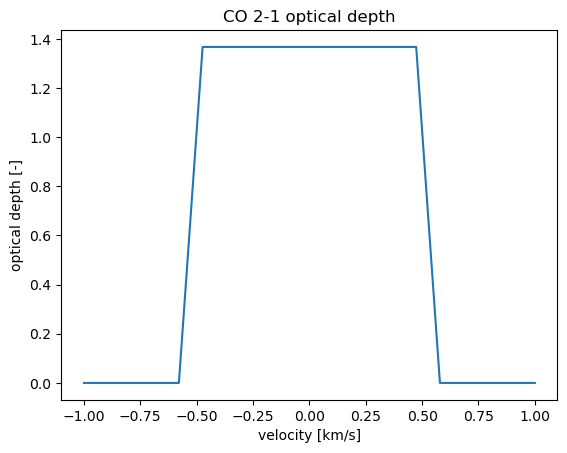

In [8]:
# define the grid of frequencies for which we want the spectrum
# and optical depth:
v = np.linspace(-width_v, width_v, 20)
nu0_21 = source.emitting_molecule.nu0[index_21]  # rest frequency of CO 2-1
nu = nu0_21 * (1 - v / constants.c)
specific_intensity = source.spectrum(output_type="specific intensity", nu=nu)
flux_density = source.spectrum(
    output_type="flux density", solid_angle=solid_angle, nu=nu
)
RJ_brightness_temp = source.spectrum(output_type="Rayleigh-Jeans", nu=nu)
Planck_brightness_temp = source.spectrum(output_type="Planck", nu=nu)
tau_nu = source.tau_nu(nu=nu)

fig, axes = plt.subplots(ncols=2, nrows=2)
fig.suptitle("CO 2-1 emission spectrum")
axes[0, 0].plot(v / constants.kilo, specific_intensity)
axes[0, 0].set_ylabel(r"specific intensity [W/m$^2$/Hz/sr]")
axes[0, 1].plot(v / constants.kilo, flux_density)
axes[0, 1].set_ylabel(r"flux density [W/m$^2$/Hz]")
for ax in (axes[0,0],axes[0,1]):
    ax.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
axes[1, 0].plot(v / constants.kilo, RJ_brightness_temp)
axes[1, 0].set_ylabel(r"R-J brightness T [K]")
axes[1, 1].plot(v / constants.kilo, Planck_brightness_temp)
axes[1, 1].set_ylabel(r"Planck brightness T [K]")
for ax in axes.ravel():
    ax.set_xlabel("velocity [km/s]")
fig.tight_layout()

_, ax = plt.subplots()
ax.set_title("CO 2-1 optical depth")
ax.plot(v / constants.kilo, tau_nu)
ax.set_xlabel("velocity [km/s]")
ax.set_ylabel(r"optical depth [-]")

We can also get the emission at the line center (i.e. rest frequency):

In [9]:
output_types = ("specific intensity", "flux density", "Rayleigh-Jeans", "Planck")
units = ("W/m2/Hz/sr", "W/m2/Hz", "K", "K")

for output_type, unit in zip(output_types, units):
    emission = source.emission_at_line_center(
        output_type=output_type,
        transitions=transitions,
        solid_angle=(solid_angle if output_type == "flux density" else None),
    )
    print(f"{output_type} at line center: {emission:.3g} {unit}")

specific intensity at line center: 1.94e-16 W/m2/Hz/sr
flux density at line center: 4.55e-31 W/m2/Hz
Rayleigh-Jeans at line center: 11.9 K
Planck at line center: 16.8 K


Finally, we can also get an overview of the basic results of our calculation for all transitions by invoking the print_results function. For each transitions, it lists the indices of the upper and lower level, the rest frequency, the excitation temperature, the fractional population of the lower and upper level, and the optical depth at the rest frequency.

In [10]:
source.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      54.06       0.122168       0.330851       0.179753
   2    1     230.538000      20.96       0.330851       0.325295        1.36716
   3    2     345.795990      16.85       0.325295       0.170079        1.84728
   4    3     461.040768      13.61       0.170079      0.0430084        1.17724
   5    4     576.267931      13.48      0.0430084     0.00675366       0.313361
   6    5     691.473076      18.68     0.00675366     0.00135013      0.0459527
   7    6     806.651806      26.13     0.00135013    0.000354136     0.00841327
   8    7     921.799700      31.90    0.000354136    0.000100267     0.00211573
   9    8    1036.912393      36.30    0.000100267    2.84454e-05    0.000589387
  10    9    1151.985452      40.42    2.84454e-05    8.00666e-06    0.000165313
  11   10    1267.014486      44.23    8.00666e-06    2.21778e-06    4.62374e-05
  12   11    1381.995105   

If we want to make another calculation with updated parameters, we can use the update_parameters function again. For example, let's change the kinetic temperature while leaving the other parameters at their old values.

In [11]:
new_Tkin = 30
source.update_parameters(Tkin=new_Tkin)
source.solve_radiative_transfer()
print(f"Tex: {source.Tex[index_21]:.3g} K")

Tex: 13.2 K


**IMPORTANT**: If you want to run `pythonradex` for a grid of parameters, **do not initialise a new `Source` instance for each set of parameters!** Setting up a new `Source` is computationally expensive, so the grid search will take much more time than needed. Instead, use the `update_parameters` method. Another notebook with an example grid search is available in the documentation.

By the way, we can of course force LTE with a high collider density.

In [12]:
LTE_collider_densities = {
    "para-H2": 1e6 / constants.centi**3,
    "ortho-H2": 3e6 / constants.centi**3,
}
source.update_parameters(collider_densities=LTE_collider_densities)
source.solve_radiative_transfer()
print(f"Tex of 2-1: {source.Tex[index_21]:.5g} K (Tkin = {new_Tkin} K)")

Tex of 2-1: 29.989 K (Tkin = 30 K)


We indeed see that now LTE is established as $T_\mathrm{ex}\approx T_\mathrm{kin}$. Of course, if it is known that LTE applies, using pythonradex to solve the radiative transfer is not necessary because the level population is known and the radiative transfer can be solved directly.

Note that for convenience, the LTE level population (i.e. Boltzmann distribution) can be directly retrieved as follows (see also the notebook explaining how to read LAMDA files):

In [13]:
# the fractional population of each level of the CO molecule
source.emitting_molecule.Boltzmann_level_population(T=new_Tkin)

array([8.93976938e-02, 2.23029118e-01, 2.57064475e-01, 2.06977272e-01,
       1.27278184e-01, 6.18780569e-02, 2.41922867e-02, 7.68060381e-03,
       1.99215058e-03, 4.23856103e-04, 7.41874485e-05, 1.07044890e-05,
       1.27532253e-06, 1.25614314e-07, 1.02391207e-08, 6.91270612e-10,
       3.86815058e-11, 1.79511697e-12, 6.91258932e-14, 2.20981693e-15,
       5.86710310e-17, 1.29422945e-18, 2.37289568e-20, 3.61720522e-22,
       4.58606540e-24, 4.83740681e-26, 4.24643017e-28, 3.10314390e-30,
       1.88830787e-32, 9.57116290e-35, 4.04203100e-37, 1.42265745e-39,
       4.17436752e-42, 1.02140043e-44, 2.08467998e-47, 3.55016042e-50,
       5.04602306e-53, 5.98779422e-56, 5.93383624e-59, 4.91229733e-62,
       3.39817892e-65])